In [38]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [39]:
# portfolio of stocks
stocks = ['LULU', 'ADBE', 'PYPL', 'NKE', 'MC.PA', 'BRK-B', 'UNH', 'NVO']

#### Download historical data from TradingView API

In [40]:
# from tvDatafeed import TvDatafeed, Interval
# tv = TvDatafeed()

# num_stocks = len(stocks)


# # days calculation
# start_date = datetime(2010, 1, 1)
# today = datetime.now()
# days_difference = (today - start_date).days

# n_bars = min(days_difference + 100, 5000)  # max 5000 bars API limit

In [41]:
# # Exchange mapping
# stock_exchanges = {
#     'LULU': 'NASDAQ',
#     'ADBE': 'NASDAQ',
#     'PYPL': 'NASDAQ',
#     'NKE': 'NYSE',
#     'MC': 'EURONEXT'
# }

# # Download function with retry and error handling
# def download_with_retry(symbol, exchange, retries=3, delay=2):
#     for attempt in range(retries):
#         try:
#             print(f"Downloading {symbol} from {exchange} (attempt {attempt+1})")
#             data = tv.get_hist(
#                 symbol=symbol, 
#                 exchange=exchange, 
#                 interval=Interval.in_daily,
#                 n_bars=1000  # circa 4 anni di dati
#             )
#             if data is not None and not data.empty:
#                 print(f"✅ {symbol}: {len(data)} rows downloaded")
#                 return data
#         except Exception as e:
#             print(f"❌ Error downloading {symbol}: {e}")
        
#         if attempt < retries - 1:
#             time.sleep(delay)
    
#     print(f"❌ Failed to download {symbol} after {retries} attempts")
#     return None

In [42]:
# # Download to DataFrame
# print("🚀 Starting data download...")
# data_dict = {}
# failed_downloads = []

# for stock, exchange in stock_exchanges.items():
#     data = download_with_retry(stock, exchange)
#     if data is not None:
#         # keep only the Close and Volume columns and rename them
#         data_dict[stock] = data[['close', 'volume']].rename(
#             columns={'close': f'{stock}_close', 'volume': f'{stock}_volume'}
#         )
#     else:
#         failed_downloads.append(stock)

# if failed_downloads:
#     print(f"⚠️ Failed to download: {failed_downloads}")

# # Combine into a single DataFrame
# if data_dict:
#     df = pd.concat(data_dict.values(), axis=1)
#     print(f"📊 Combined DataFrame shape: {df.shape}")
#     print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
#     print("\nFirst 5 rows:")
#     print(df.head())
# else:
#     print("❌ No data downloaded successfully")

In [43]:
# # count nan
# nan_counts = df.isna().sum()
# print("NaN counts per column:")
# print(nan_counts[nan_counts > 0])

# """
# NaN counts per column:
# LULU_close     1000
# LULU_volume    1000
# ADBE_close     1000
# ADBE_volume    1000
# PYPL_close     1000
# PYPL_volume    1000
# NKE_close      1000
# NKE_volume     1000
# MC_close       1000
# MC_volume      1000
# dtype: int64
# """

Unfortunately, the dataset contains a significant amount of missing data, particularly for the 'close' and 'volume' columns of each stock. We need to find a different API for the data extraction process of the selected stocks.

#### Download historical data from yf API

In [44]:
# import yfinance as yf

# start_date = "2020-01-01"
# end_date = datetime.now().strftime("%Y-%m-%d")

# # Download historical data from yf API
# data = yf.download(stocks, start=start_date, end=end_date, group_by='ticker')

# # download data to csv
# data.to_csv("stocks_data.csv")

#### Download analysis from csv downloaded data

In [45]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("stocks_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Forward fill missing values for each column
df = df.fillna(method='ffill')

# Convert all values to float
df = df.astype(float)

In [46]:
# # Here you can plot the charts for every ticker

# # For every ticker, plot Close
# import matplotlib.pyplot as plt

# for ticker in df.columns.levels[0]:
#     plt.figure(figsize=(12, 6))
#     plt.plot(df[ticker]['Close'], label=ticker)
#     plt.title(f"{ticker} Close Price")
#     plt.xlabel("Date")
#     plt.ylabel("Close Price")
#     plt.legend()
#     plt.show()

#### LULU Volume Analysis

In [47]:
# df LULU, df level 0 = 'LULU'
lulu = df['LULU']

# drop Open, High, Low
lulu = lulu.drop(['Open', 'High', 'Low'], axis=1)

lulu.head()

Price,Close,Volume
Date,,
2020-01-02,233.419998,1449300.0
2020-01-03,232.639999,1315400.0
2020-01-06,235.429993,1460700.0
2020-01-07,233.699997,1367900.0
2020-01-08,237.270004,1883900.0


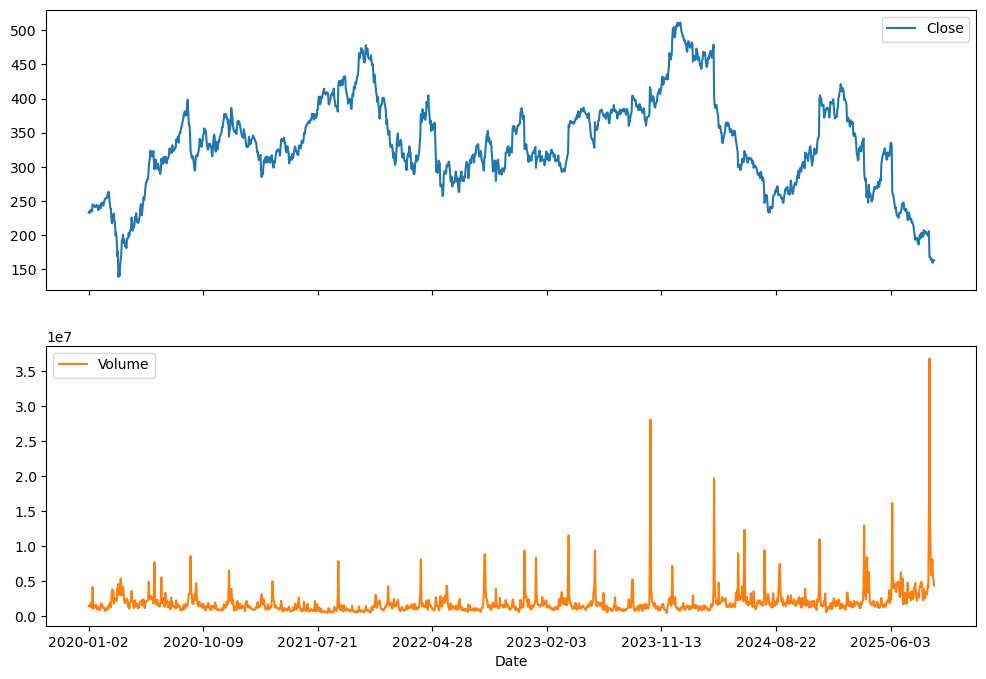

In [48]:
# Simple plot for ticker LULU with Close and Volume
df['LULU'][['Close', 'Volume']].plot(subplots=True, figsize=(12, 8));

In [49]:
import plotly.io as pio
pio.renderers.default = 'vscode'

In [50]:
import plotly.express as px
import plotly.graph_objects as go

px.histogram(lulu, x='Volume', y='Close', nbins=150, orientation='h').show()

In [51]:
# Histogram: sum of volume for price bin 
hist = go.Histogram(
    y=lulu['Close'],
    x=lulu['Volume'],
    nbinsy=150,
    orientation='h',
    name='Volume Profile',
    marker_color='#B0C4DE',
    opacity=0.5,         # Bins opacity
    xaxis='x2',
)

# Line plot: Close prices over time
line = go.Scatter(
    x=lulu.index,
    y=lulu['Close'],
    mode='lines',
    name='LULU Close',
    marker_color='blue',
    xaxis='x',
    yaxis='y',
)

# First we plot the histogram, then the line chart
fig = go.Figure([hist, line])

fig.update_layout(
    xaxis=dict(
        title='Date',
        anchor='y',
        domain=[0, 1],
        showgrid=False,
        side='bottom'
    ),
    xaxis2=dict(
        title='Sum of Volume',
        overlaying='x',
        side='top',
        showgrid=False
    ),
    yaxis=dict(
        title='Close Price',
        showgrid=True
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    height=600,
    title='Volume Profile & LULU Close Prices'
)

fig.show()

In [52]:
# Kernel Density Estimator (KDE) plot
from scipy import stats, signal

"""
stats provides statistical functions and probability distributions for data analysis.

signal offers tools for signal processing, such as filtering, peak detection, 
and Fourier transforms.

These modules are commonly used for advanced data analysis and scientific computing in Python.
"""

kde_factor = 0.05
num_samples = 500
kde = stats.gaussian_kde(lulu.Close,weights=lulu.Volume,bw_method=kde_factor)
xr = np.linspace(lulu.Close.min(),lulu.Close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(lulu.Close, lulu.Volume, xr, kdy).show()

The Kernel Density Estimator (KDE) is a non-parametric method to estimate the probability density function of a continuous variable. It smooths the observed data using a kernel function, providing a continuous curve that represents the distribution of the data. KDE is useful for visualizing the underlying structure of the data, identifying modes, and comparing distributions.

In [53]:
# Volume Peaks
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
fig = get_dist_plot(lulu.Close, lulu.Volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [54]:
# Find peaks, peak_props
peaks, peak_props = signal.find_peaks(kdy, prominence=0.00001)

pkx = xr[peaks]
pky = kdy[peaks]

# Fig 
fig = get_dist_plot(lulu.Close, lulu.Volume, xr, kdy)

# Add peaks markers
fig.add_trace(go.Scatter(
    x=pkx, y=pky,
    mode="markers",
    name="Peaks",
    marker=dict(color="blue", size=8, symbol="circle")
))

# Draw vertical lines from the peaks downwards (prominence)
for x, y0, prom in zip(pkx, pky, peak_props["prominences"]):
    fig.add_shape(
        type="line",
        xref="x", yref="y",
        x0=x, x1=x,
        y0=y0, y1=y0 - prom,
        line=dict(color="red", width=2)
    )

fig.show()

In [55]:
# Peak Width
width_range=1
peaks, peak_props = signal.find_peaks(kdy, prominence=0.00001, width=width_range)

left_ips = peak_props['left_ips']
right_ips = peak_props['right_ips']
width_x0 = xr.min() + (left_ips * ticks_per_sample)
width_x1 = xr.min() + (right_ips * ticks_per_sample)
width_y = peak_props['width_heights']

fig = get_dist_plot(lulu.Close, lulu.Volume, xr, kdy)
fig.add_trace(go.Scatter(name='Peaks', x=pkx, y=pky, mode='markers', marker=pk_marker_args))

for x0, x1, y in zip(width_x0, width_x1, width_y):
    fig.add_shape(type='line',
        xref='x', yref='y',
        x0=x0, y0=y, x1=x1, y1=y,
        line=dict(
            color='red',
            width=2,
        )
    )
fig.show()

In [56]:
# !pip install marketprofile

# # https://marketprofile.readthedocs.io/en/latest/

In [57]:
from market_profile import MarketProfile

mp = MarketProfile(lulu)
mp_slice = mp[lulu.index.min():lulu.index.max()]

In [58]:
mp_slice.profile

Close
139.00    4568200.0
140.40    3809600.0
144.90    3764700.0
154.90    2989600.0
159.90    8061200.0
            ...    
508.85     816400.0
509.25     688700.0
510.00    1179500.0
511.05     896600.0
511.30     918300.0
Name: Volume, Length: 1211, dtype: float64

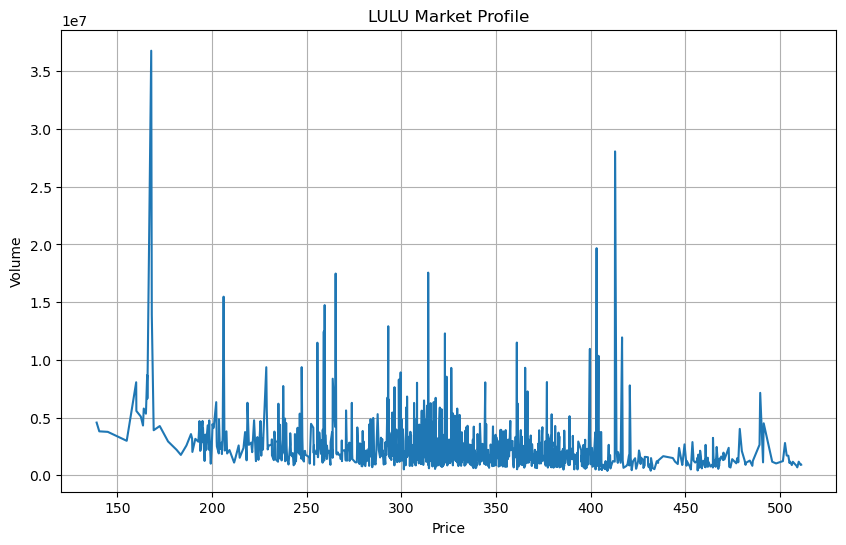

In [59]:
# plot mp_slice.profile
plt.figure(figsize=(10,6))
plt.plot(mp_slice.profile.index, mp_slice.profile.values)
plt.title('LULU Market Profile')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.grid()
plt.show()

In [60]:
# mp_slice.initial_balance()
# mp_slice.open_range()

In [61]:
mp_slice.poc_price

np.float64(167.85)

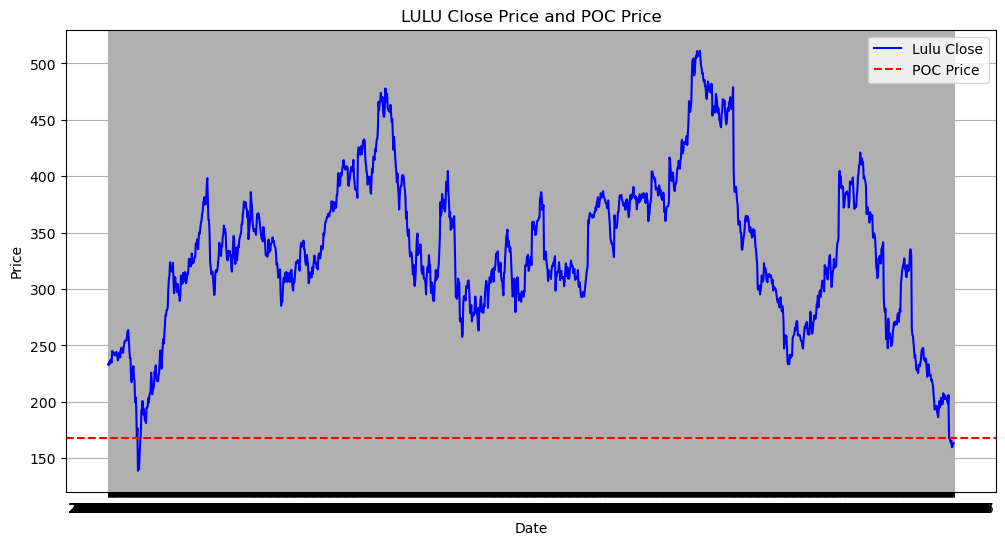

In [62]:
# plot lulu.Close and mp_slice.poc_price as horizontal line 
plt.figure(figsize=(12,6))
plt.plot(lulu.index, lulu['Close'], label='Lulu Close', color='blue')
plt.axhline(mp_slice.poc_price, label='POC Price', color='red', linestyle='--')
plt.title('LULU Close Price and POC Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [63]:
mp_slice.profile_range

(np.float64(139.0), np.float64(511.3))

In [64]:
mp_slice.value_area

(np.float64(139.0), np.float64(355.25))

In [65]:
mp_slice.balanced_target

np.float64(-175.60000000000005)

In [66]:
mp_slice.low_value_nodes

Close
154.90    2989600.0
163.50    4315200.0
165.05    5338000.0
165.80    6645300.0
169.15    3906800.0
            ...    
498.05    1029200.0
505.15    1063000.0
506.35     887300.0
509.25     688700.0
511.05     896600.0
Name: Volume, Length: 395, dtype: float64

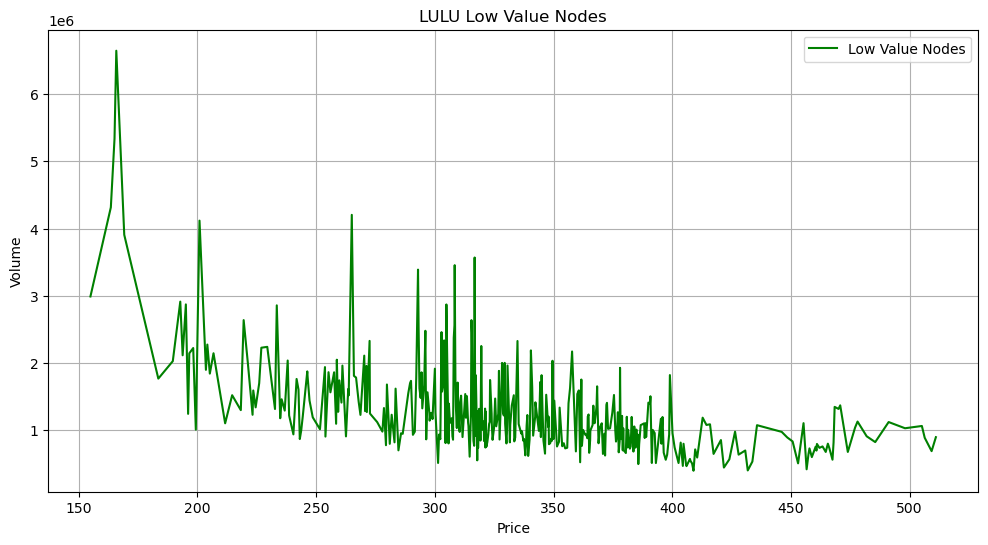

In [67]:
# plot mp_slice.low_value_nodes
plt.figure(figsize=(12,6))
plt.plot(mp_slice.low_value_nodes.index, mp_slice.low_value_nodes.values, label='Low Value Nodes', color='green')
plt.title('LULU Low Value Nodes')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

In [68]:
mp_slice.high_value_nodes

Close
159.90     8061200.0
163.90     5785900.0
165.70     8678900.0
167.85    36788900.0
172.35     4267500.0
             ...    
491.50     4504700.0
502.75     2799000.0
505.40     1187800.0
506.90     1174800.0
510.00     1179500.0
Name: Volume, Length: 394, dtype: float64

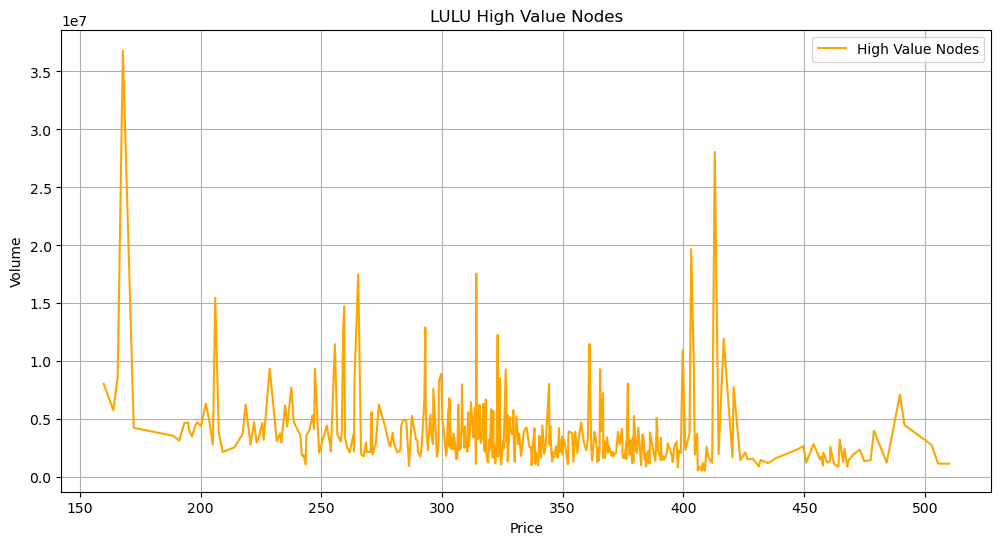

In [69]:
# plot mp_slice.high_value_nodes
plt.figure(figsize=(12,6))
plt.plot(mp_slice.high_value_nodes.index, mp_slice.high_value_nodes.values, label='High Value Nodes', color='orange')
plt.title('LULU High Value Nodes')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

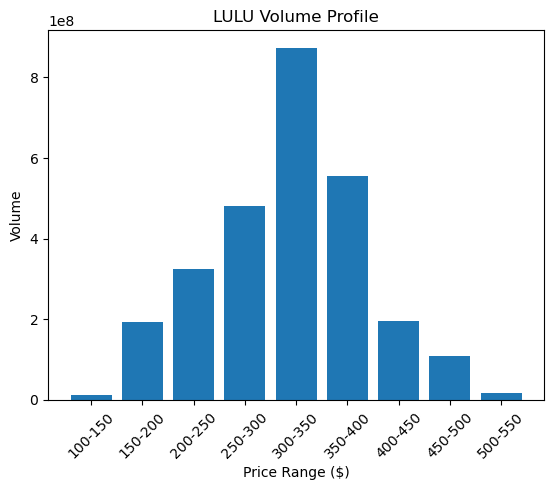

In [70]:
# Calculate the price range and bin edges every $50
bin_size = 50
min_price = np.floor(lulu.Close.min() / bin_size) * bin_size
max_price = np.ceil(lulu.Close.max() / bin_size) * bin_size
bin_edges = np.arange(min_price, max_price + bin_size, bin_size)
num_bins = len(bin_edges) - 1

# Use np.histogram to sum volumes in each price bin
volume_profile, _ = np.histogram(lulu.Close, bins=bin_edges, weights=lulu.Volume)

# Plot the Volume Profile
plt.bar(range(num_bins), volume_profile, width=0.8, align='center')
plt.xticks(
    range(num_bins),
    [f'{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f}' for i in range(num_bins)],
    rotation=45
)
plt.xlabel('Price Range ($)')
plt.ylabel('Volume')
plt.title('LULU Volume Profile')
plt.show()

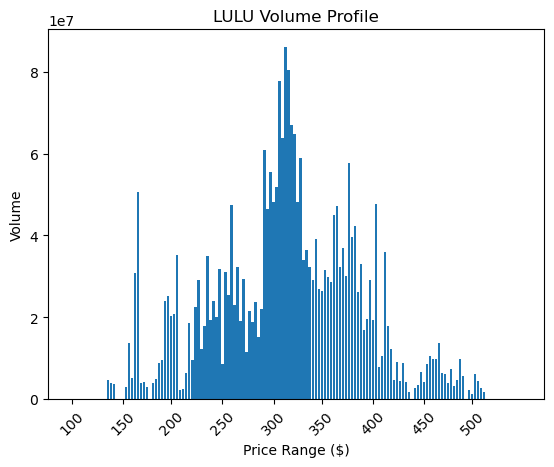

In [71]:
# Volume profile with 150 bins, labels every 50$
num_bins = 150
min_price = np.floor(lulu.Close.min() / 50) * 50
max_price = np.ceil(lulu.Close.max() / 50) * 50
bin_edges = np.linspace(min_price, max_price, num_bins + 1)

# Calculate the aggregated volume for each bin
volume_profile, _ = np.histogram(lulu.Close, bins=bin_edges, weights=lulu.Volume)

# Find the positions of the ticks closest to the multiples of 50
xtick_labels = []
xtick_positions = []
for price in np.arange(min_price, max_price + 1, 50):
    # Find the bin closest to the desired tick
    idx = np.argmin(np.abs(bin_edges - price))
    if idx < num_bins:  # only if the bin is valid
        xtick_positions.append(idx)
        xtick_labels.append(f'{int(price)}')

# Plot
plt.bar(range(num_bins), volume_profile, width=0.8, align='center')
plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.xlabel('Price Range ($)')
plt.ylabel('Volume')
plt.title('LULU Volume Profile')
plt.show()

#### Plot of Volume Profile for All Stocks

In [72]:
stocks_ = stocks.copy()

for stock in stocks_:
    # Usa una variabile temporanea per ogni stock
    df_stock = df[stock][['Close', 'Volume']]

    # plot
    hist = go.Histogram(
        y=df_stock['Close'],
        x=df_stock['Volume'],
        nbinsy=150,
        orientation='h',
        name='Volume Profile',
        marker_color='#B0C4DE',
        opacity=0.5,
        xaxis='x2',
    )

    line = go.Scatter(
        x=df_stock.index,
        y=df_stock['Close'],
        mode='lines',
        name='Close',
        marker_color='blue',
        xaxis='x',
        yaxis='y',
    )

    fig = go.Figure([hist, line])

    fig.update_layout(
        xaxis=dict(
            title='Date',
            anchor='y',
            domain=[0, 1],
            showgrid=False,
            side='bottom'
        ),
        xaxis2=dict(
            title='Sum of Volume',
            overlaying='x',
            side='top',
            showgrid=False
        ),
        yaxis=dict(
            title='Close Price',
            showgrid=True
        ),
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        ),
        height=600,
        title=f'Volume Profile & {stock} Close Prices'
    )

    fig.show()

In [73]:
# !pip install -U kaleido

# kaleido library is used for static image export of Plotly figures, 
# required for saving figures as images

In [74]:
# # Same iteration for all stocks as previous cell, just added the image saving with kaleido

# stocks_ = ['LULU', 'PYPL', 'NKE', 'ADBE']

# for stock in stocks_:
#     df_stock = df[stock][['Close', 'Volume']]

#     hist = go.Histogram(
#         y=df_stock['Close'],
#         x=df_stock['Volume'],
#         nbinsy=150,
#         orientation='h',
#         name='Volume Profile',
#         marker_color='#B0C4DE',
#         opacity=0.5,
#         xaxis='x2',
#     )

#     line = go.Scatter(
#         x=df_stock.index,
#         y=df_stock['Close'],
#         mode='lines',
#         name='Close',
#         marker_color='blue',
#         xaxis='x',
#         yaxis='y',
#     )

#     fig = go.Figure([hist, line])

#     fig.update_layout(
#         xaxis=dict(
#             title='Date',
#             anchor='y',
#             domain=[0, 1],
#             showgrid=False,
#             side='bottom'
#         ),
#         xaxis2=dict(
#             title='Sum of Volume',
#             overlaying='x',
#             side='top',
#             showgrid=False
#         ),
#         yaxis=dict(
#             title='Close Price',
#             showgrid=True
#         ),
#         legend=dict(
#             orientation='h',
#             yanchor='bottom',
#             y=1.02,
#             xanchor='right',
#             x=1
#         ),
#         height=600,
#         title=f'Volume Profile & {stock} Close Prices'
#     )

#     fig.show()

#     # Salva il grafico come JPG
#     fig.write_image(f"{stock}_volume_profile.jpg", format="jpg")